<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

<b>Описание проекта</b>

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

<b>Цель проекта</b>

Обучить модель и классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

<b>Задачи проекта</b>

Построить модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. [Загрузим и подготовим данные.](#step_1)
2. [Обучим разные модели.](#step_2)
3. [Сделаем выводы.](#step_3)

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

<a id="step_1"></a>
## Подготовка

Загрузим необходимые библиотеки

In [1]:
# pip install pandas

In [2]:
# pip install spacy

In [3]:
# pip install nltk

In [4]:
# pip install catboost

In [5]:
# pip install scikit-learn

In [6]:
# import en_core_web_sm
import nltk
import numpy as np
import pandas as pd
import re
import spacy
import tqdm
import warnings

from catboost import CatBoostClassifier
from joblib import dump, load
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from tqdm.notebook import tqdm
from typing import Any, Dict

In [7]:
warnings.filterwarnings("ignore")

Загрузим наш файл

In [8]:
try:
    df = pd.read_csv('toxic_comments.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

Напишем функцию для просмотра наших данных

In [9]:
def first_look(df: pd.DataFrame, limit_na_category: int = 10) -> None:
    '''Функция получения первичной информации о датафрейме'''
    print('------------- Первые 5 строк ------------')
    display(df.head())
    print('')
    print('')
    print('------------- Типы данных ------------')
    print(df.info())
    print('')
    print('')
    print('------------- Пропуски ------------')
    count = 0
    shape_0 = df.shape[0]
    for element in df.columns:
        if df[element].isna().sum() > 0:
            print(
                element,
                ' - ',
                df[element].isna().sum(),
                'пропусков, ',
                round(df[element].isna().sum() * 100 / shape_0,2),
                '% от числа строк.'
            )
            count = +1
    if count == 0:
        print('Пропусков НЕТ')
        print('')
        print('')
    print ('------------- Дубликаты ------------')
    if df.duplicated().sum() > 0:
        print('Дубликатов: ', df.duplicated().sum())
    else:
        print('Дубликатов НЕТ')
    # ищем, есть ли категориальные столбцы (содержащие до limit_na_category уникальных значений) в датафрейме
    min_unique = limit_na_category + 1
    for element in df._get_numeric_data().columns:
        min_unique = min(min_unique, df[element].nunique())
        if min_unique <= limit_na_category:
            print('')
    print('')
    print('------------- Категориальные признаки ------------')
    for element in df._get_numeric_data().columns:
        if df[element].nunique() <= limit_na_category:
            print(element, ': ', df[element].nunique(), 'категории - ', df[element].unique(), )

Взглянем на наши данные

In [10]:
first_look(df)

------------- Первые 5 строк ------------


,Unnamed: 0,Unnamed: 0.1,text,toxic
0,0,0,Explanation\nWhy the edits made under my usern...,0
1,1,1,D'aww! He matches this background colour I'm s...,0
2,2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,4,"You, sir, are my hero. Any chance you remember...",0




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Unnamed: 0    159292 non-null  int64 
 1   Unnamed: 0.1  159292 non-null  int64 
 2   text          159292 non-null  object
 3   toxic         159292 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.9+ MB
None


------------- Пропуски ------------
Пропусков НЕТ


------------- Дубликаты ------------
Дубликатов НЕТ


------------- Категориальные признаки ------------
toxic :  2 категории -  [0 1]


Наши данные состоят из двух столбцов. Столбкец 'text' содержит текст комментария, а столбец 'toxic' - целевой признак

Посмотрим на распределение целевого признака

<AxesSubplot:>

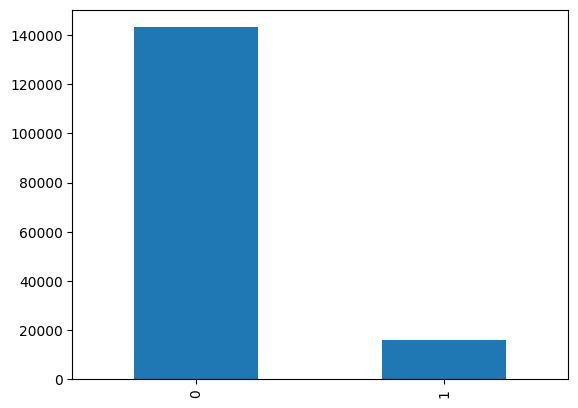

In [11]:
df['toxic'].value_counts().plot(kind='bar')

Наблюдаем явный дисбаланс классов

Нам необходимо ощистить текст от нежелательных символом и лемматизировать его

Функция очистки текста от нежелательных символов

In [12]:
def clear_text(text: str) -> str:
    
    text = text.lower()
    
    text = re.sub(r'[^a-zA-Z ]', ' ', text).strip()
    
    # Удаляем html теги
    text = re.sub(r'<[^>]+>', ' ', text)
    
    # Удаляем единичные символы
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    
    # Удаляем единычные символы из начала строки
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text) 
    
    # Заменяем несколько пробелов на один
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    # Удаляем 'b'
    text = re.sub(r'^b\s+', '', text)
        
    return text

Очистим текст от нежелательных символов

In [13]:
df['text'] = df['text'].apply(clear_text)
display(df.head())

,Unnamed: 0,Unnamed: 0.1,text,toxic
0,0,0,explanation why the edits made under my userna...,0
1,1,1,d aww he matches this background colour m seem...,0
2,2,2,hey man m really not trying to edit war it jus...,0
3,3,3,more can make any real suggestions on improvem...,0
4,4,4,you sir are my hero any chance you remember wh...,0


Для токенизации и лемматизации воспользуемся моделью en_core_web_sm

In [14]:
nlp = spacy.load("en_core_web_sm-3.7.1")

In [15]:
def lemmatize(text: str) -> str:
    temp = []
    for i in nlp(text):
        if i.is_stop == False:
            temp.append(i.lemma_)
    return " ".join(temp)

In [16]:
tqdm.pandas()
df['text'] = df['text'].progress_apply(lemmatize)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [17]:
df.head()

,Unnamed: 0,Unnamed: 0.1,text,toxic
0,0,0,explanation edit username hardcore metallica f...,0
1,1,1,d aww match background colour m seemingly stuc...,0
2,2,2,hey man m try edit war guy constantly remove r...,0
3,3,3,real suggestion improvement wonder section sta...,0
4,4,4,sir hero chance remember page,0


Сохраним наши данные для последующего пропуска шага лемматизации

In [18]:
dump(df, 'toxic_comments_lemmas.csv')

['toxic_comments_lemmas.csv']

Загрузим наши данные сохраненные после лемматизации

In [19]:
df = load('toxic_comments_lemmas.csv')

На данном шаге мы просмотрели наши данные, очистили их и лемматизировали.

Обучим наши модели на подготовленных данных

<a id="step_2"></a>
## Обучение

Разобьем наши данные на обучающую и тестовую выборки в соотношении 75:25

In [20]:
features = df['text']
target = df['toxic']
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

Создадим признаки с учетом стоп-слов и выделим целевые признаки

In [21]:
# Загрузим стоп-слова
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

# Создадим счетчик, указав в нем стоп-слова
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
# Посчитаем TD-IDF для корпуса текстов
tf_idf = count_tf_idf.fit(features_train)
# Создадим признаки
features_train = tf_idf.transform(features_train)
features_test = tf_idf.transform(features_test)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/s.prisyazhny/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Функция обучения наших моделей, поиска наилучшей метрики f1 и подобранных параметров

In [22]:
def model_look(model: Any, parameters: Dict, features: np.array, target: np.array):
    model_grid = GridSearchCV(model, parameters, cv=5, scoring='f1', verbose=0)
    model_grid.fit(features, target)
    return model_grid.best_score_, model_grid.best_params_

Обучим модель логистической регресии

In [23]:
parameters = {'C': range(25, 28, 1), 'max_iter': range(6, 10, 1)}
f1, best_parameters = model_look(
    LogisticRegression(random_state=12345, solver='liblinear'),
    parameters,
    features_train,
    target_train
)
print('Лучшие параметры модели линейной регрессии:', best_parameters)
print('Дали f1 модели:', f1)

Лучшие параметры модели линейной регрессии: {'C': 26, 'max_iter': 8}
Дали f1 модели: 0.7705561707891173


In [24]:
results = pd.DataFrame ({'model':['LogisticRegression'], 'best_parameters_train':[best_parameters], 'f1_train':[f1]})
results

,model,best_parameters_train,f1_train
0,LogisticRegression,"{'C': 26, 'max_iter': 8}",0.770556


Обучим модель дерева решений

In [25]:
parameters = {'max_depth': range(122, 125, 1)}
f1, best_parameters = model_look(
    DecisionTreeClassifier(random_state=12345),
    parameters,
    features_train,
    target_train
)
print('Лучшие параметры модели дерева решений:', best_parameters)
print('Дали f1 модели:', f1)

Лучшие параметры модели дерева решений: {'max_depth': 123}
Дали f1 модели: 0.7291204591867367


In [26]:
results = results.append(
    {'model':'DecisionTreeClassifier', 'best_parameters_train':best_parameters, 'f1_train':f1},
    ignore_index=True
)
results

,model,best_parameters_train,f1_train
0,LogisticRegression,"{'C': 26, 'max_iter': 8}",0.770556
1,DecisionTreeClassifier,{'max_depth': 123},0.729120


Обучим модель случайного леса

In [27]:
parameters = {'max_depth': range(213, 216, 1), 'n_estimators': range(3, 6, 1)}
f1, best_parameters = model_look(
    RandomForestClassifier(random_state=12345),
    parameters,
    features_train,
    target_train
)
print('Лучшие параметры модели случайного леса:', best_parameters)
print('Дали f1 модели:', f1)

Лучшие параметры модели случайного леса: {'max_depth': 214, 'n_estimators': 4}
Дали f1 модели: 0.5842265785882731


In [28]:
results = results.append(
    {'model':'RandomForestClassifier', 'best_parameters_train':best_parameters, 'f1_train':f1},
    ignore_index=True
)
results

,model,best_parameters_train,f1_train
0,LogisticRegression,"{'C': 26, 'max_iter': 8}",0.770556
1,DecisionTreeClassifier,{'max_depth': 123},0.729120
2,RandomForestClassifier,"{'max_depth': 214, 'n_estimators': 4}",0.584227


Обучим модель CatBoostClassifier

In [29]:
parameters = {'iterations': range(1000, 1150, 50)}
f1, best_parameters = model_look(
    CatBoostClassifier(random_state=12345, logging_level='Silent'),
    parameters,
    features_train,
    target_train
)
print('Лучшие параметры модели CatBoostClassifier:', best_parameters)
print('Дали f1 модели:', f1)

Лучшие параметры модели CatBoostClassifier: {'iterations': 1050}
Дали f1 модели: 0.7473409085261427


In [30]:
results = results.append(
    {'model':'CatBoostClassifier', 'best_parameters_train':best_parameters, 'f1_train':f1},
    ignore_index=True
)
results

,model,best_parameters_train,f1_train
0,LogisticRegression,"{'C': 26, 'max_iter': 8}",0.770556
1,DecisionTreeClassifier,{'max_depth': 123},0.729120
2,RandomForestClassifier,"{'max_depth': 214, 'n_estimators': 4}",0.584227
3,CatBoostClassifier,{'iterations': 1050},0.747341


На данном этапе мы обучили наши данные моделями машинного обучения и выявили оптимальные гиперпараметры для этих моделей. Проверим полученные значения на тестовых данных

Функция валидации моделей на тестовой выборке и занесения результата метрики f1  в таблицу

In [31]:
def ml_result(
    model: Any,
    features_train: np.array,
    target_train: np.array,
    features_test: np.array,
    target_test: np.array
) -> float:
        
    model.fit(features_train, target_train)
    
    predictions = model.predict(features_test)
    
    f1 = f1_score(target_test, predictions)
      
    return f1

Проверим модель логистической регрессии на тестовом наборе

In [32]:
f1 = ml_result(
    LogisticRegression(
        random_state=12345, solver='liblinear', C=26, max_iter=8
    ),
    features_train,
    target_train,
    features_test,
    target_test
)
results.loc[0, 'f1_test'] = f1
results

,model,best_parameters_train,f1_train,f1_test
0,LogisticRegression,"{'C': 26, 'max_iter': 8}",0.770556,0.78663
1,DecisionTreeClassifier,{'max_depth': 123},0.729120,NaN
2,RandomForestClassifier,"{'max_depth': 214, 'n_estimators': 4}",0.584227,NaN
3,CatBoostClassifier,{'iterations': 1050},0.747341,NaN


Проверим модель дерева решений на тестовом наборе

In [33]:
f1 = ml_result(DecisionTreeClassifier(
    random_state=12345, max_depth=123), features_train, target_train, features_test, target_test
              )
results.loc[1, 'f1_test'] = f1
results

,model,best_parameters_train,f1_train,f1_test
0,LogisticRegression,"{'C': 26, 'max_iter': 8}",0.770556,0.786630
1,DecisionTreeClassifier,{'max_depth': 123},0.729120,0.735188
2,RandomForestClassifier,"{'max_depth': 214, 'n_estimators': 4}",0.584227,NaN
3,CatBoostClassifier,{'iterations': 1050},0.747341,NaN


Проверим модель случайного дерева на тестовом наборе

In [34]:
f1 = ml_result(RandomForestClassifier(
    random_state=12345, max_depth=214, n_estimators=4), features_train, target_train, features_test, target_test
              )
results.loc[2, 'f1_test'] = f1
results

,model,best_parameters_train,f1_train,f1_test
0,LogisticRegression,"{'C': 26, 'max_iter': 8}",0.770556,0.786630
1,DecisionTreeClassifier,{'max_depth': 123},0.729120,0.735188
2,RandomForestClassifier,"{'max_depth': 214, 'n_estimators': 4}",0.584227,0.642857
3,CatBoostClassifier,{'iterations': 1050},0.747341,NaN


Проверим модель CatBoostClassifier на тестовом наборе

In [35]:
f1 = ml_result(CatBoostClassifier(
    random_state=12345, iterations=1050, logging_level='Silent'
), features_train, target_train, features_test, target_test
              )
results.loc[3, 'f1_test'] = f1
results

,model,best_parameters_train,f1_train,f1_test
0,LogisticRegression,"{'C': 26, 'max_iter': 8}",0.770556,0.786630
1,DecisionTreeClassifier,{'max_depth': 123},0.729120,0.735188
2,RandomForestClassifier,"{'max_depth': 214, 'n_estimators': 4}",0.584227,0.642857
3,CatBoostClassifier,{'iterations': 1050},0.747341,0.759516


На данном этапе мы обучили модели машинного обучения на тренировочной выборке и проверили их на тестовой выборке. Лучшими характеристиками и гарантированно успешно по условиям задачи себя показали модели логистической регрессии и CatBoostClassifier.

<a id="step_3"></a>
## Выводы

Согласно условиям задачи мы можем выделить две модели, которые справились с возложенными на них функциями.

Но, согласно полученных данных, рекомендовать мы будем только модель логистической регресии по двум причинам:

1. Более точное предсказание.

2. Намного меньшее время как обучения, так и предсказаний.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны